<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/10wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상 

{{<video https://youtu.be/playlist?list=PLQqh36zP38-xl7f2bcPTKMVCe3kHM380M&si=5SO7pni3fXX4kK-4 >}}

# 2. Imports 

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 3. 예비학습: optimizer 사용 고급 

`-` 주어진 자료가 아래와 같다고 하자. 

In [2]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ones= torch.ones(100).reshape(-1,1)
X = torch.concat([ones,x],axis=-1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

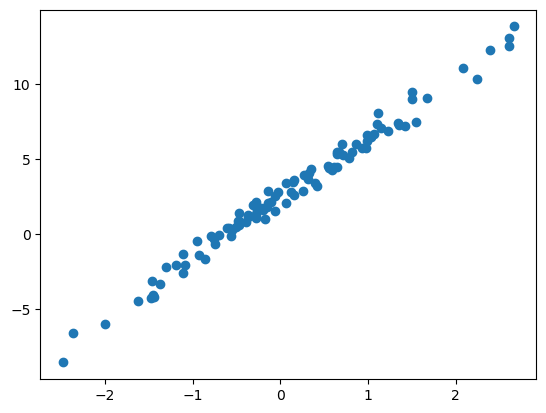

In [3]:
plt.plot(x,y,'o')

`-` 문제1: 아래와 같이 최초의 직선을 생성하였다. 

In [4]:
# What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
# loss_fn = torch.nn.MSELoss()
# for epocs in range(50):
#     ## step1
#     yhat = X@What
#     ## step2
#     loss = (y-yhat).T @ (y-yhat)
#     # loss = torch.sum((y-yhat)**2)       # SSE : Sum of Square error
#     ## step3
#     loss.backward()
#     ## step4
#     What.data = What.data -0.001*What.grad    # 여기서 learning rate가 기존 0.001 에서 0.1 으로 대폭? 커졌다. SSE에서 MSE로 가면서, loss가 평균화로 작아지는 것에 대해 기울기 grad 값도 같이 작아져서, update가 더뎌지는걸 learning rate를 높여서 보상? 했다고 생각하면 될 듯.
#     What.grad =None
# What

In [5]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)

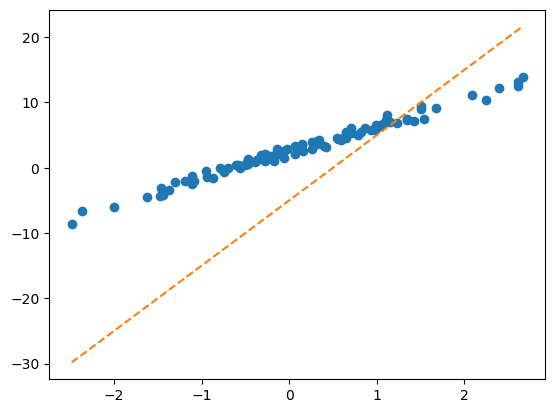

In [6]:
plt.plot(x,y,'o')
plt.plot(x,X@What.data,'--')

`torch.optim.SGD`를 이용하여 What을 update하라. 학습률은 0.1로 설정하고 30회 update하라. 

In [7]:
# net  
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([What],lr=0.1)   # 학습하고싶은 파라미터를 list로 전달
#--#
for epoc in range(30):
    # step1 
    yhat = X@What 
    # step2
    loss = loss_fn(yhat,y)
    # step3 
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()

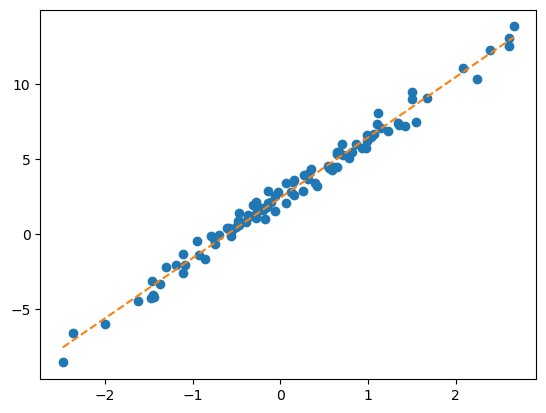

In [8]:
plt.plot(x,y,'o')
plt.plot(x,X@What.data,'--')

`-` 문제2: 아래와 같이 최초의 직선을 생성하였다. 

In [9]:
w = torch.tensor(10.0,requires_grad=True)
b = torch.tensor(-5.0,requires_grad=True)

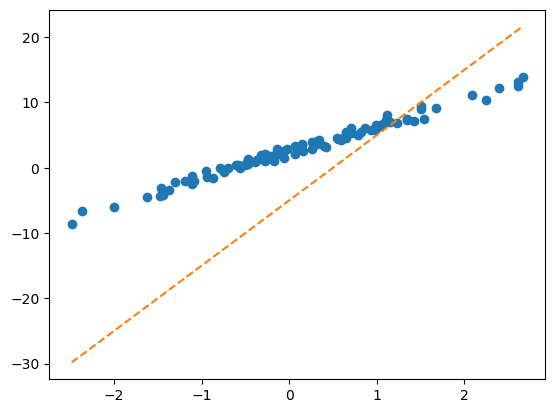

In [10]:
plt.plot(x,y,'o')
plt.plot(x,(x*w + b).data,'--')

`torch.optim.SGD`를 이용하여 What을 update하라. 학습률은 0.1로 설정하고 30회 update하라. 

In [11]:
# net  
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([w,b],lr=0.1)
#--#
for epoc in range(30):
    # step1 
    yhat = x*w+b 
    # step2
    loss = loss_fn(yhat,y)
    # step3 
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()

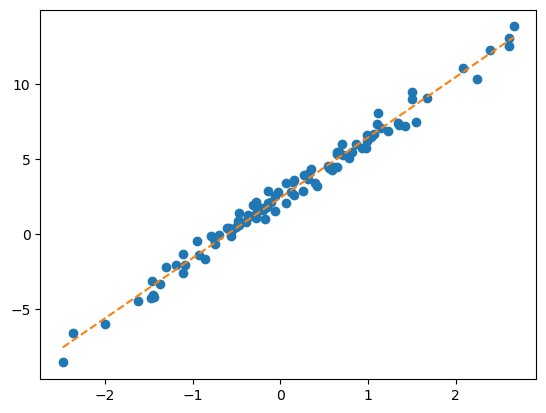

In [12]:
plt.plot(x,y,'o')
plt.plot(x,(x*w + b).data,'--')

# 4. MF-based 추천시스템

ref: <https://namu.wiki/w/나는%20SOLO>

## A. Data: 나는 SOLO

`-` Data 

In [13]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


`-` 데이터를 이해할 때 필요한 가정들 -- 제가 마음대로 설정했어요.. 

- 궁합이 잘맞으면 5점, 잘 안맞으면 0점 이다. 
- MBTI 성향에 따라서 궁함의 정도가 다르다. 특히 I/E의 성향일치가 중요하다. 
- 하니는 모든 사람들과 대체로 궁합이 잘 맞는다. 
- 하니는 I성향의 사람들과 좀 더 잘 맞는다. 

## B. Fit / Predict

`-` 목표: NaN을 추정 

`-` 수동추론: 그럴듯한 숫자를 추정해보자. 

- 옥순(IN),영식(IN)의 궁합은? $\to$ 둘다 IN 이므로 잘 맞을듯 $\to$ 4.0 정도? 
- 영자(IN),다호(ES)의 궁합은? $\to$ 잘 안맞을듯 
- 하니(I),영호(IS)의 궁합은? $\to$ 하니는 모두 좋아하므로 기본적으로 4.5 정도 + 하니는 I성향이므로 더 잘 맞을듯 $\to$ 거의 4.9 아닐까?

`-` 좀 더 체계적인 추론 전략: (1) 사람들이 가지고 있는 성향 (2) 사람자체의 절대매력을 수치화 하자. 

- 옥순(IN)의 IN성향, 옥순(IN)의 매력 = (1.22, 0.49), 1.21
- 영식(IN)의 IN성향, 영식(IN)의 매력 = (1.20, 0.50), 1.20
- 영자(IN)의 IN성향, 영자(IN)의 매력 = (1.17 ,0.44), 1.25
- 다호(ES)의 IN성향, 다호(ES)의 매력 = (-1.22 ,-0.60), 1.15
- 하니(I)의 IN성향, 하니(I)의 매력 = (0.20,0.00), 3.60
- 영호(IS)의 IS성향, 영호(IS)의 매력 = (1.23 , -0.7), 1.11

**(1)** 옥순(IN)과 영식(IN)의 궁합 $\approx$ 옥순의I성향$\times$영식의I성향 $+$ 옥순의N성향$\times$영식의N성향 $+$ 옥순의매력 $+$ 영식의매력 

In [14]:
옥순성향 = torch.tensor([1.22,0.49]).reshape(1,2)
옥순매력 = torch.tensor(1.21)
영식성향 = torch.tensor([1.20,0.5]).reshape(1,2)
영식매력 = torch.tensor(1.2)
((옥순성향*영식성향).sum() + 옥순매력 + 영식매력) # 옥순과 영식의 궁합: a ∘ b 로 내적구함 + 이후에 매력을 더함 
(옥순성향 @ 영식성향.T + 옥순매력 + 영식매력) # 옥순과 영식의 궁합: a.T @ b 로 내적구함 + 이후에 매력을 더함

tensor([[4.1190]])

**(2)** 영자(IN)와 다호(ES)의 궁합 $\approx$ 영자I성향$\times$다호I성향 $+$ 영자N성향$\times$다호의N성향 $+$ 영자의매력 $+$ 다호의매력 

In [15]:
영자성향 = torch.tensor([1.17,0.44]).reshape(1,2)
영자매력 = torch.tensor(1.25).reshape(1,1)
다호성향 = torch.tensor([-1.22,-0.6]).reshape(1,2)
다호매력 = torch.tensor(1.15).reshape(1,1)
((영자성향*다호성향).sum() + 영자성향 + 다호성향)
(영자성향 @ 다호성향.T + 영자매력 + 다호매력)

tensor([[0.7086]])

**(3)** 하니(I)와 영호(IS)의 궁합 $\approx$ 하니I성향$\times$영호I성향 $+$ 하니N성향$\times$영호의N성향 $+$ 하니의매력 $+$ 영호의매력 

In [16]:
하니성향 = torch.tensor([0.2,0]).reshape(1,2)
하니매력 = torch.tensor(3.6)
영호성향 = torch.tensor([1.23,-0.7]).reshape(1,2)
영호매력 = torch.tensor(1.11)
((하니성향*영호성향).sum() + 하니매력 + 영호매력)
(하니성향 @ 영호성향.T + 하니매력 + 영호매력)

tensor([[4.9560]])

> 전체적으로 그럴싸함 

`-` 전체 사용자의 설정값 

In [17]:
옥순성향 = torch.tensor([1.22,0.49]).reshape(1,2)
영자성향 = torch.tensor([1.17,0.44]).reshape(1,2)
정숙성향 = torch.tensor([1.21,-0.45]).reshape(1,2)
영숙성향 = torch.tensor([1.20,-0.50]).reshape(1,2)
순자성향 = torch.tensor([-1.20,0.51]).reshape(1,2)
현숙성향 = torch.tensor([-1.23,0.48]).reshape(1,2)
서연성향 = torch.tensor([-1.20,-0.48]).reshape(1,2)
보람성향 = torch.tensor([-1.19,-0.49]).reshape(1,2)
하니성향 = torch.tensor([0.2,0]).reshape(1,2)
W = torch.concat([옥순성향,영자성향,정숙성향,영숙성향,순자성향,현숙성향,서연성향,보람성향,하니성향])
b1 = torch.tensor([1.21,1.25,1.10,1.11,1.12,1.13,1.14,1.12,3.6]).reshape(-1,1) 
W,b1

(tensor([[ 1.2200,  0.4900],
         [ 1.1700,  0.4400],
         [ 1.2100, -0.4500],
         [ 1.2000, -0.5000],
         [-1.2000,  0.5100],
         [-1.2300,  0.4800],
         [-1.2000, -0.4800],
         [-1.1900, -0.4900],
         [ 0.2000,  0.0000]]),
 tensor([[1.2100],
         [1.2500],
         [1.1000],
         [1.1100],
         [1.1200],
         [1.1300],
         [1.1400],
         [1.1200],
         [3.6000]]))

In [18]:
영식성향 = torch.tensor([1.20,0.5]).reshape(1,2)
영철성향 = torch.tensor([1.22,0.45]).reshape(1,2)
영호성향 = torch.tensor([1.23,-0.7]).reshape(1,2)
광수성향 = torch.tensor([1.21,-0.6]).reshape(1,2)
상철성향 = torch.tensor([-1.28,0.6]).reshape(1,2)
영수성향 = torch.tensor([-1.24,0.5]).reshape(1,2)
규빈성향 = torch.tensor([-1.20,-0.5]).reshape(1,2)
다호성향 = torch.tensor([-1.22,-0.6]).reshape(1,2)
M = torch.concat([영식성향,영철성향,영호성향,광수성향,상철성향,영수성향,규빈성향,다호성향]) # 각 column은 남성출연자의 성향을 의미함
b2 = torch.tensor([1.2,1.10,1.11,1.25,1.18,1.11,1.15,1.15]).reshape(-1,1)
M,b2

(tensor([[ 1.2000,  0.5000],
         [ 1.2200,  0.4500],
         [ 1.2300, -0.7000],
         [ 1.2100, -0.6000],
         [-1.2800,  0.6000],
         [-1.2400,  0.5000],
         [-1.2000, -0.5000],
         [-1.2200, -0.6000]]),
 tensor([[1.2000],
         [1.1000],
         [1.1100],
         [1.2500],
         [1.1800],
         [1.1100],
         [1.1500],
         [1.1500]]))

`-` 아래의 행렬곱 관찰 

In [19]:
W.shape , M.T.shape , b1.shape , b2.T.shape , (b1+b2.T).shape

(torch.Size([9, 2]),
 torch.Size([2, 8]),
 torch.Size([9, 1]),
 torch.Size([1, 8]),
 torch.Size([9, 8]))

In [20]:
W @ M.T + (b1 + b2.T)

tensor([[4.1190, 4.0189, 3.4776, 3.6422, 1.1224, 1.0522, 0.6510, 0.5776],
        [4.0740, 3.9754, 3.4911, 3.6517, 1.1964, 1.1292, 0.7760, 0.7086],
        [3.5270, 3.4737, 4.0133, 4.0841, 0.4612, 0.4846, 1.0230, 1.0438],
        [3.5000, 3.4490, 4.0460, 4.1120, 0.4540, 0.4820, 1.0700, 1.0960],
        [1.1350, 0.9855, 0.3970, 0.6120, 4.1420, 3.9730, 3.4550, 3.4280],
        [1.0940, 0.9454, 0.3911, 0.6037, 4.1724, 4.0052, 3.5160, 3.4926],
        [0.6600, 0.5600, 1.1100, 1.2260, 3.5680, 3.4980, 3.9700, 4.0420],
        [0.6470, 0.5477, 1.1093, 1.2241, 3.5292, 3.4606, 3.9430, 4.0158],
        [5.0400, 4.9440, 4.9560, 5.0920, 4.5240, 4.4620, 4.5100, 4.5060]])

---저거 따져보자--- 

${\bf W} = \begin{bmatrix}
1.2200 & 0.4900 \\
1.1700 & 0.4400 \\
1.2100 & -0.4500 \\
1.2000 & -0.5000 \\
-1.2000 & 0.5100 \\
-1.2300 & 0.4800 \\
-1.2000 & -0.4800 \\
-1.1900 & -0.4900 \\
0.2000 & 0.0000
\end{bmatrix}$

${\bf M}^\top = \begin{bmatrix}
1.2000 & 1.2200 & 1.2300 & 1.2100 & -1.2800 & -1.2400 & -1.2000 & -1.2200 \\
0.5000 & 0.4500 & -0.7000 & -0.6000 & 0.6000 & 0.5000 & -0.5000 & -0.6000
\end{bmatrix}$

${\bf W} @ {\bf M}^\top = \begin{bmatrix}
1.7090 & 1.7089 & 1.1576 & 1.1822 & -1.2676 & -1.2678 & -1.7090 & -1.7824 \\
1.6240 & 1.6254 & 1.1311 & 1.1517 & -1.2336 & -1.2308 & -1.6240 & -1.6914 \\
1.2270 & 1.2737 & 1.8033 & 1.7341 & -1.8188 & -1.7254 & -1.2270 & -1.2062 \\
1.1900 & 1.2390 & 1.8260 & 1.7520 & -1.8360 & -1.7380 & -1.1900 & -1.1640 \\
-1.1850 & -1.2345 & -1.8330 & -1.7580 &  1.8420 &  1.7430 &  1.1850 &  1.1580 \\
-1.2360 & -1.2846 & -1.8489 & -1.7763 &  1.8624 &  1.7652 &  1.2360 &  1.2126 \\
-1.6800 & -1.6800 & -1.1400 & -1.1640 &  1.2480 &  1.2480 &  1.6800 &  1.7520 \\
-1.6730 & -1.6723 & -1.1207 & -1.1459 &  1.2292 &  1.2306 &  1.6730 &  1.7458 \\
0.2400 &  0.2440 &  0.2460 &  0.2420 & -0.2560 & -0.2480 & -0.2400 & -0.2440
\end{bmatrix}$

$\begin{align*} bias =~& \begin{bmatrix}
1.2100 \\
1.2500 \\
1.1000 \\
1.1100 \\
1.1200 \\
1.1300 \\
1.1400 \\
1.1200 \\
3.6000
\end{bmatrix} +\begin{bmatrix}
1.2000 & 1.1000 & 1.1100 & 1.2500 & 1.1800 & 1.1100 & 1.1500 & 1.1500
\end{bmatrix}\\ \\ 
=~& \begin{bmatrix}
2.4100 & 2.3100 & 2.3200 & 2.4600 & 2.3900 & 2.3200 & 2.3600 & 2.3600 \\
2.4500 & 2.3500 & 2.3600 & 2.5000 & 2.4300 & 2.3600 & 2.4000 & 2.4000 \\
2.3000 & 2.2000 & 2.2100 & 2.3500 & 2.2800 & 2.2100 & 2.2500 & 2.2500 \\
2.3100 & 2.2100 & 2.2200 & 2.3600 & 2.2900 & 2.2200 & 2.2600 & 2.2600 \\
2.3200 & 2.2200 & 2.2300 & 2.3700 & 2.3000 & 2.2300 & 2.2700 & 2.2700 \\
2.3300 & 2.2300 & 2.2400 & 2.3800 & 2.3100 & 2.2400 & 2.2800 & 2.2800 \\
2.3400 & 2.2400 & 2.2500 & 2.3900 & 2.3200 & 2.2500 & 2.2900 & 2.2900 \\
2.3200 & 2.2200 & 2.2300 & 2.3700 & 2.3000 & 2.2300 & 2.2700 & 2.2700 \\
4.8000 & 4.7000 & 4.7100 & 4.8500 & 4.7800 & 4.7100 & 4.7500 & 4.7500
\end{bmatrix} \end{align*}$

${\bf W} @ {\bf M}^\top + bias = \begin{bmatrix}
4.1190 & 4.0189 & 3.4776 & 3.6422 & 1.1224 & 1.0522 & 0.6510 & 0.5776 \\
4.0740 & 3.9754 & 3.4911 & 3.6517 & 1.1964 & 1.1292 & 0.7760 & 0.7086 \\
3.5270 & 3.4737 & 4.0133 & 4.0841 & 0.4612 & 0.4846 & 1.0230 & 1.0438 \\
3.5000 & 3.4490 & 4.0460 & 4.1120 & 0.4540 & 0.4820 & 1.0700 & 1.0960 \\
1.1350 & 0.9855 & 0.3970 & 0.6120 & 4.1420 & 3.9730 & 3.4550 & 3.4280 \\
1.0940 & 0.9454 & 0.3911 & 0.6037 & 4.1724 & 4.0052 & 3.5160 & 3.4926 \\
0.6600 & 0.5600 & 1.1100 & 1.2260 & 3.5680 & 3.4980 & 3.9700 & 4.0420 \\
0.6470 & 0.5477 & 1.1093 & 1.2241 & 3.5292 & 3.4606 & 3.9430 & 4.0158 \\
5.0400 & 4.9440 & 4.9560 & 5.0920 & 4.5240 & 4.4620 & 4.5100 & 4.5060
\end{bmatrix}$

`-` ${\bf W} @ {\bf M}^\top + bias$ 의 (1,1)의 원소값을 계산해보면 아래와 같다. 

- 옥순의I성향$\times$영식의I성향 $+$ 옥순의N성향$\times$영식의N성향 $+$ 옥순의매력 $+$ 영식의매력 = 4.1190
- $1.220 \times 1.2000 + 0.4900 \times 0.5000 + 1.2100 + 2.4100 = 4.1190$

`-` 궁합매트릭스: ${\bf W} @ {\bf M}^\top + bias$를 계산하면 (9,8) 인 행렬이 나올텐데 이 행렬의 $(i,j)$의 원소는 $i$-th 여성출연자와 $j$-th 남성출연자가 얼마나 잘 맞는지를 나타내는 숫자가 된다. (숫자가 높을수록 잘 맞음) 편의상 이 수업에서는 이 매트릭스를 "궁합매트릭스" 라고 정의하자. 

`-` 주어진 자료와 우리가 임의로 만든 궁합매트릭스를 비교해보자. 

In [21]:
print(f"주어진자료:\n{np.array(df_view)}")
print(f"궁합매트릭스:\n{np.array(W @ M.T + b1 + b2.T).round(2)}")

주어진자료:
[[ nan 4.02 3.45 3.42 0.84 1.12 0.43 0.49]
 [3.93 3.99 3.63 3.43 0.98 0.96 0.52  nan]
 [3.52 3.42 4.05 4.06 0.39  nan 0.93 0.99]
 [3.43 3.57  nan 3.95 0.56 0.52 0.89 0.89]
 [1.12  nan 0.59 0.43 4.01 4.16 3.52 3.38]
 [0.94 1.05 0.32 0.45 4.02 3.78  nan 3.54]
 [0.51 0.56 0.88 0.89 3.5  3.64 4.04 4.1 ]
 [0.48 0.51 1.03  nan 3.52 4.   3.82  nan]
 [4.85 4.82  nan 4.98 4.53 4.39 4.45 4.52]]
궁합매트릭스:
[[4.12 4.02 3.48 3.64 1.12 1.05 0.65 0.58]
 [4.07 3.98 3.49 3.65 1.2  1.13 0.78 0.71]
 [3.53 3.47 4.01 4.08 0.46 0.48 1.02 1.04]
 [3.5  3.45 4.05 4.11 0.45 0.48 1.07 1.1 ]
 [1.14 0.99 0.4  0.61 4.14 3.97 3.46 3.43]
 [1.09 0.95 0.39 0.6  4.17 4.01 3.52 3.49]
 [0.66 0.56 1.11 1.23 3.57 3.5  3.97 4.04]
 [0.65 0.55 1.11 1.22 3.53 3.46 3.94 4.02]
 [5.04 4.94 4.96 5.09 4.52 4.46 4.51 4.51]]


`-` 우리의 전략

1. ${\bf W} @ {\bf M}^\top + bias$의 값과 `df_view` 의 값이 **`nan`을 제외한 곳에서** 거의 비슷하게 되도록 ${\bf W}$, ${\bf M}$, $bias$를 잘 때려맞추면 되는것 아니야?

2. 1을 만족하는 ${\bf W}$, ${\bf M}$, $bias$를 찾았으면 그 숫자들을 이용하여 `df_view`의 `nan` 을 추정한다. 

`-` 따라서 모형은 아래와 같이 볼 수 있다. 

$${\tt df\_view} \approx {\bf W}@{\bf M}^\top + bias$$

`-` 아래의 정보를 참고하여 위의 수식을 다시 정리하면..

|W|M|여성특징|남성특징| I궁합| N궁합 | bias | yhat |y| 
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|옥순(IN)|영철(IN)|1.22, 0.49 | 1.22, 0.45 |1.4884^[1.22 \*1.22 = 1.4884]| 0.2205^[0.49 \* 0.45 = 0.2205]| 2.31^[1.21+1.1 = 2.31]|4.0189|4.02|
|옥순(IN)|영호(IS)|1.22, 0.49 | 1.23, -0.7| 1.1576^[1.22 \*1.23 = 1.5006]| -0.3423^[0.49 \* -0.7 = -0.3423]|2.32^[1.21+1.11 = 2.32]|3.4776|3.45|
|...|...|... | ... | ...|...|
|하니(I)|영식(IN)|0.20, 0.00 | 1.20, 0.5| 0.24| 0 |4.8|5.04|4.85|
|...|...|... | ... | ...|...|

- 걱정1: 5.0이 넘는 값도 있네? 잘못잡으면 음수가 나올지도? 
- 걱정2: 저러한 yhat (4.0189, 3.4776, 5.04)을 만드는게 꼭 저 조합만 있는게 아님. 당장에 남성의 바이어스에 일괄적으로 -2를 넣고 여성의 바이어스에 일괄적으로 +2를 해도 성립함.

`-` (걱정은 뒤로 하고) `yhat` $\approx$ `y` 를 만족하도록 해보자! (1) 아무 `yhat` 을 구한다. (2) `yhat`과 `y`가 비슷한 정도를 측정한다. (3) 더 적당한 `yhat`값을 update한다. 

- `yhat`은 어떻게 구하지? (여성특징$\otimes$남성특징).sum() + bias? 
- 그럼 여성특징,남성특징,여성bias(=여성매력),남성bias(=남성매력)는 어떻게 구하지?? 생각해보니까 데이터에서 주어진건 아니잖아??

`-` `여성특징`,`남성특징`, `여성bais`,`남성bais` 를 어떻게 만들지?

- 그전엔 어떻게 했지?? `W`을 보고 적당히 특징을 상상하고 `여성특징`,`여성bias`의 값을 때려넣음 + `M`를 보고 적당히 특징을 상상하고 `남성특징`, `남성bias`의 값을 채워 넣음. 
- 자동화하려면? `W` $\to$ `여성특징`, `W` $\to$ `여성bias`, `M` $\to$ `남성특징`, `M` $\to$ `남성bias` 인 함수를 만들자.

`-` 앞으로 할일1: 아래와 같은 함수들을 만들자. 
    
- 옥순 $\to$ 옥순의 특징 = (1.22, 0.49) 
- 옥순 $\to$ 옥순의 매력 = 1.22
- 영철 $\to$ 영철의 특징 = (1.22, 0.45) 
- 영철 $\to$ 영철의 매력 = 1.22 
...


`-` 앞으로 할일2: 우리가 익숙한 셋팅 (step1~4)
    
1. `여성특징`, `여성bias`, `남성특징`, `남성bias`  $\to$ `yhat` 를 수행
2. `y` $\approx$ `yhat` 인지 체크: `loss = loss_fn(yhat,y)`
3. `loss.backward()`
4. 더 나은 `여성특징`, `여성bias`, `남성특징`, `남성bias` 로 update!

## C. 할일1의 구현

`-` dataframe의 변형 

In [22]:
df_view

,영식(IN),영철(IN),영호(IS),광수(IS),상철(EN),영수(EN),규빈(ES),다호(ES)
옥순(IN),NaN,4.02,3.45,3.42,0.84,1.12,0.43,0.49
영자(IN),3.93,3.99,3.63,3.43,0.98,0.96,0.52,NaN
정숙(IS),3.52,3.42,4.05,4.06,0.39,NaN,0.93,0.99
영숙(IS),3.43,3.57,NaN,3.95,0.56,0.52,0.89,0.89
순자(EN),1.12,NaN,0.59,0.43,4.01,4.16,3.52,3.38
현숙(EN),0.94,1.05,0.32,0.45,4.02,3.78,NaN,3.54
서연(ES),0.51,0.56,0.88,0.89,3.50,3.64,4.04,4.10
보람(ES),0.48,0.51,1.03,NaN,3.52,4.00,3.82,NaN
하니(I),4.85,4.82,NaN,4.98,4.53,4.39,4.45,4.52


In [23]:
df_view.stack().reset_index()

,level_0,level_1,0
0,옥순(IN),영철(IN),4.02
1,옥순(IN),영호(IS),3.45
2,옥순(IN),광수(IS),3.42
3,옥순(IN),상철(EN),0.84
4,옥순(IN),영수(EN),1.12
...,...,...,...
58,하니(I),광수(IS),4.98
59,하니(I),상철(EN),4.53
60,하니(I),영수(EN),4.39
61,하니(I),규빈(ES),4.45


In [24]:
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
df_train

,W,M,y
0,옥순(IN),영철(IN),4.02
1,옥순(IN),영호(IS),3.45
2,옥순(IN),광수(IS),3.42
3,옥순(IN),상철(EN),0.84
4,옥순(IN),영수(EN),1.12
...,...,...,...
58,하니(I),광수(IS),4.98
59,하니(I),상철(EN),4.53
60,하니(I),영수(EN),4.39
61,하니(I),규빈(ES),4.45


`-` 이름을 숫자화

In [25]:
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}

In [26]:
df_train['X1']= df_train['W'].map(w)
df_train['X2']= df_train['M'].map(m)
df_train

,W,M,y,X1,X2
0,옥순(IN),영철(IN),4.02,0,1
1,옥순(IN),영호(IS),3.45,0,2
2,옥순(IN),광수(IS),3.42,0,3
3,옥순(IN),상철(EN),0.84,0,4
4,옥순(IN),영수(EN),1.12,0,5
...,...,...,...,...,...
58,하니(I),광수(IS),4.98,8,3
59,하니(I),상철(EN),4.53,8,4
60,하니(I),영수(EN),4.39,8,5
61,하니(I),규빈(ES),4.45,8,6


결국, X1 , X2 가 주어질때 y를 추측하는 문제로 귀결됨
- 이때 원핫인코딩이 필요함

`-` 텐서화 + one_hot-인코딩 

In [27]:
X1 = torch.tensor(df_train['X1'])
X2 = torch.tensor(df_train['X2'])
print((X1.dtype))
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()

torch.int64


In [28]:
X1

tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
        6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8])

In [29]:
X2

tensor([1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 6, 7, 0, 1, 3,
        4, 5, 6, 7, 0, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 7, 0, 1, 2, 3, 4, 5,
        6, 7, 0, 1, 2, 4, 5, 6, 0, 1, 3, 4, 5, 6, 7])

In [30]:
E1.dtype,E1 ,E1.shape

(torch.float32,
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.

In [31]:
E2

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0

In [32]:
print(f"y.shape: {y.shape},\t y.dtype: {y.dtype}")
print(f"X1.shape: {X1.shape},\t X1.dtype: {X1.dtype} // X1.unique: {X1.unique()}")  # 여자 index
print(f"X2.shape: {X2.shape},\t X2.dtype: {X2.dtype} // X2.unique: {X2.unique()}")  # 남자 index
print(f"E1.shape: {E1.shape},\t E1.dtype: {E1.dtype} -- shape에서 9는 여성이 9명이라는 의미")
print(f"E2.shape: {E2.shape},\t E2.dtype: {E2.dtype} -- shape에서 8은 남성이 8명이라는 의미")

y.shape: torch.Size([100, 1]),	 y.dtype: torch.float32
X1.shape: torch.Size([63]),	 X1.dtype: torch.int64 // X1.unique: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
X2.shape: torch.Size([63]),	 X2.dtype: torch.int64 // X2.unique: tensor([0, 1, 2, 3, 4, 5, 6, 7])
E1.shape: torch.Size([63, 9]),	 E1.dtype: torch.float32 -- shape에서 9는 여성이 9명이라는 의미
E2.shape: torch.Size([63, 8]),	 E2.dtype: torch.float32 -- shape에서 8은 남성이 8명이라는 의미


`-` `X1` -> `여성특징`, `X1` -> `여성bias`, `X2` -> `남성특징`, `X2` -> `남성bias` 구현  

In [33]:
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False) # "E1->여성특징"인 함수 
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False) # "E1->여성bias"인 함수 
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False) # "E2->남성특징"인 함수 
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False) # "E2->남성bias"인 함수 

## D. 할일2의 구현 -- step1~4 수행 

`-` step1: yhat을 구하자. 

In [34]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False) # "E1->여성특징"인 함수 
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False) # "E1->여성bias"인 함수 
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False) # "E2->남성특징"인 함수 
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False) # "E2->남성bias"인 함수 
W_features = l1(E1) # l1(onehot(X1))
W_bias = b1(E1) # b1(onehot(X1))
M_features = l2(E2) # l2(onehot(X2))
M_bias = b2(E2) # b2(onehot(X2))

In [35]:
E1.shape , E1

(torch.Size([63, 9]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 

In [36]:
list(W_features)  # 옥순을 넣었을때, I와 N성향을 출력해주는 함수 l1에 E1을 input으로 넣은 결과

[tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.1156,  0.2082], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([-0.2823,  0.3231], grad_fn=<UnbindBackward0>),
 tensor([ 0.1201, -0.1724], grad_fn=<UnbindBackward0>),
 tensor([ 0.1201, -0.1724], grad_fn=<UnbindBackward0>),
 tensor([ 0.1201, -0.1724], grad_fn=<UnbindBackward0>),
 tensor([ 0.1201, -0.1724], grad_fn=<UnbindBackw

In [37]:
list(M_features)

[tensor([ 0.0621, -0.0075], grad_fn=<UnbindBackward0>),
 tensor([0.1415, 0.2070], grad_fn=<UnbindBackward0>),
 tensor([-0.0449,  0.2928], grad_fn=<UnbindBackward0>),
 tensor([0.2502, 0.1697], grad_fn=<UnbindBackward0>),
 tensor([-0.2042,  0.0928], grad_fn=<UnbindBackward0>),
 tensor([-0.0980,  0.0474], grad_fn=<UnbindBackward0>),
 tensor([ 0.3091, -0.2111], grad_fn=<UnbindBackward0>),
 tensor([ 0.1425, -0.1902], grad_fn=<UnbindBackward0>),
 tensor([ 0.0621, -0.0075], grad_fn=<UnbindBackward0>),
 tensor([0.1415, 0.2070], grad_fn=<UnbindBackward0>),
 tensor([-0.0449,  0.2928], grad_fn=<UnbindBackward0>),
 tensor([0.2502, 0.1697], grad_fn=<UnbindBackward0>),
 tensor([-0.2042,  0.0928], grad_fn=<UnbindBackward0>),
 tensor([-0.0980,  0.0474], grad_fn=<UnbindBackward0>),
 tensor([ 0.1425, -0.1902], grad_fn=<UnbindBackward0>),
 tensor([ 0.0621, -0.0075], grad_fn=<UnbindBackward0>),
 tensor([0.1415, 0.2070], grad_fn=<UnbindBackward0>),
 tensor([-0.0449,  0.2928], grad_fn=<UnbindBackward0>),
 t

In [38]:
list(W_bias)

[tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([-0.0210], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([0.3022], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([-0.0259], grad_fn=<UnbindBackward0>),
 tensor([0.1251], gr

In [39]:
list(M_bias)

[tensor([-0.1884], grad_fn=<UnbindBackward0>),
 tensor([0.2234], grad_fn=<UnbindBackward0>),
 tensor([-0.1377], grad_fn=<UnbindBackward0>),
 tensor([-0.3145], grad_fn=<UnbindBackward0>),
 tensor([0.0662], grad_fn=<UnbindBackward0>),
 tensor([-0.2995], grad_fn=<UnbindBackward0>),
 tensor([0.1305], grad_fn=<UnbindBackward0>),
 tensor([0.3028], grad_fn=<UnbindBackward0>),
 tensor([-0.1884], grad_fn=<UnbindBackward0>),
 tensor([0.2234], grad_fn=<UnbindBackward0>),
 tensor([-0.1377], grad_fn=<UnbindBackward0>),
 tensor([-0.3145], grad_fn=<UnbindBackward0>),
 tensor([0.0662], grad_fn=<UnbindBackward0>),
 tensor([-0.2995], grad_fn=<UnbindBackward0>),
 tensor([0.3028], grad_fn=<UnbindBackward0>),
 tensor([-0.1884], grad_fn=<UnbindBackward0>),
 tensor([0.2234], grad_fn=<UnbindBackward0>),
 tensor([-0.1377], grad_fn=<UnbindBackward0>),
 tensor([-0.3145], grad_fn=<UnbindBackward0>),
 tensor([-0.2995], grad_fn=<UnbindBackward0>),
 tensor([0.1305], grad_fn=<UnbindBackward0>),
 tensor([0.3028], grad

In [45]:

sig = torch.nn.Sigmoid()
score = (W_features*M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias # score중 음수가 있을 수 있다.
yhat = sig(score)*5 # 0~1 사이의 양수로 정규화하기위해 sigmoid 함수를 사용하고, scailing해준다.y = torch.tensor(df_train['y']).float().reshape(-1,1)
y = torch.tensor(df_train['y']).float().reshape(-1,1)


In [41]:
score[:5] , yhat[:5]

(tensor([[-0.2181],
         [ 0.2292],
         [-0.0925],
         [-0.3291],
         [ 0.0881]], grad_fn=<SliceBackward0>),
 tensor([[2.2284],
         [2.7852],
         [2.3845],
         [2.0923],
         [2.6101]], grad_fn=<SliceBackward0>))

`-` step2: 손실계산 

In [46]:
yhat.shape , y.shape

(torch.Size([63, 1]), torch.Size([63, 1]))

In [47]:
loss_fn = torch.nn.MSELoss()
loss = loss_fn(yhat,y)

`-` step3: 미분 

(미분전)

In [48]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

(tensor([[-0.1156, -0.2823,  0.1201,  0.3112,  0.1358, -0.2962,  0.1086, -0.2071,
          -0.0864],
         [ 0.2082,  0.3231, -0.1724, -0.2224,  0.0670,  0.1536, -0.0552,  0.2843,
          -0.1426]]),
 tensor([[-0.0210,  0.3022, -0.0259,  0.1251, -0.2812,  0.2052,  0.1129, -0.2435,
           0.2790]]),
 tensor([[ 0.1425,  0.0621,  0.1415, -0.0449,  0.2502, -0.2042, -0.0980,  0.3091],
         [-0.1902, -0.0075,  0.2070,  0.2928,  0.1697,  0.0928,  0.0474, -0.2111]]),
 tensor([[ 0.3028, -0.1884,  0.2234, -0.1377, -0.3145,  0.0662, -0.2995,  0.1305]]))

In [49]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(None, None, None, None)

(미분)

In [50]:
loss.backward()

(미분후)

In [51]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

(tensor([[-0.1156, -0.2823,  0.1201,  0.3112,  0.1358, -0.2962,  0.1086, -0.2071,
          -0.0864],
         [ 0.2082,  0.3231, -0.1724, -0.2224,  0.0670,  0.1536, -0.0552,  0.2843,
          -0.1426]]),
 tensor([[-0.0210,  0.3022, -0.0259,  0.1251, -0.2812,  0.2052,  0.1129, -0.2435,
           0.2790]]),
 tensor([[ 0.1425,  0.0621,  0.1415, -0.0449,  0.2502, -0.2042, -0.0980,  0.3091],
         [-0.1902, -0.0075,  0.2070,  0.2928,  0.1697,  0.0928,  0.0474, -0.2111]]),
 tensor([[ 0.3028, -0.1884,  0.2234, -0.1377, -0.3145,  0.0662, -0.2995,  0.1305]]))

In [55]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(tensor([[ 0.0125, -0.0184,  0.0226,  0.0183,  0.0050,  0.0058,  0.0141,  0.0276,
          -0.0295],
         [-0.0172,  0.0171, -0.0282, -0.0106,  0.0072,  0.0231,  0.0107, -0.0233,
          -0.0265]]),
 tensor([[ 0.1172,  0.0943, -0.0167,  0.1680, -0.0704,  0.1955,  0.1052, -0.0075,
          -0.5161]]),
 tensor([[-0.0145, -0.0087, -0.0224, -0.0196,  0.0313,  0.0104, -0.0032,  0.0270],
         [ 0.0383,  0.0184,  0.0313,  0.0375, -0.0164,  0.0008,  0.0108, -0.0092]]),
 tensor([[ 0.1859, -0.1176,  0.2194, -0.0823, -0.1017, -0.0458, -0.0408,  0.0526]]))

`-` step4: update 

(옵티마이저 선언)

In [62]:
list(l1.parameters()) , l1.weight.data.shape , b1.weight.data.shape

([Parameter containing:
  tensor([[-0.1156, -0.2823,  0.1201,  0.3112,  0.1358, -0.2962,  0.1086, -0.2071,
           -0.0864],
          [ 0.2082,  0.3231, -0.1724, -0.2224,  0.0670,  0.1536, -0.0552,  0.2843,
           -0.1426]], requires_grad=True)],
 torch.Size([2, 9]),
 torch.Size([1, 9]))

In [65]:
list(l1.parameters())

[Parameter containing:
 tensor([[-0.1156, -0.2823,  0.1201,  0.3112,  0.1358, -0.2962,  0.1086, -0.2071,
          -0.0864],
         [ 0.2082,  0.3231, -0.1724, -0.2224,  0.0670,  0.1536, -0.0552,  0.2843,
          -0.1426]], requires_grad=True)]

In [66]:
params = list(l1.parameters())+list(l2.parameters())+list(b1.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 

(update전)

In [67]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

(tensor([[-0.1156, -0.2823,  0.1201,  0.3112,  0.1358, -0.2962,  0.1086, -0.2071,
          -0.0864],
         [ 0.2082,  0.3231, -0.1724, -0.2224,  0.0670,  0.1536, -0.0552,  0.2843,
          -0.1426]]),
 tensor([[-0.0210,  0.3022, -0.0259,  0.1251, -0.2812,  0.2052,  0.1129, -0.2435,
           0.2790]]),
 tensor([[ 0.1425,  0.0621,  0.1415, -0.0449,  0.2502, -0.2042, -0.0980,  0.3091],
         [-0.1902, -0.0075,  0.2070,  0.2928,  0.1697,  0.0928,  0.0474, -0.2111]]),
 tensor([[ 0.3028, -0.1884,  0.2234, -0.1377, -0.3145,  0.0662, -0.2995,  0.1305]]))

In [68]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(tensor([[ 0.0125, -0.0184,  0.0226,  0.0183,  0.0050,  0.0058,  0.0141,  0.0276,
          -0.0295],
         [-0.0172,  0.0171, -0.0282, -0.0106,  0.0072,  0.0231,  0.0107, -0.0233,
          -0.0265]]),
 tensor([[ 0.1172,  0.0943, -0.0167,  0.1680, -0.0704,  0.1955,  0.1052, -0.0075,
          -0.5161]]),
 tensor([[-0.0145, -0.0087, -0.0224, -0.0196,  0.0313,  0.0104, -0.0032,  0.0270],
         [ 0.0383,  0.0184,  0.0313,  0.0375, -0.0164,  0.0008,  0.0108, -0.0092]]),
 tensor([[ 0.1859, -0.1176,  0.2194, -0.0823, -0.1017, -0.0458, -0.0408,  0.0526]]))

(update)

In [69]:
optimizr.step()

(update후)

In [70]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

(tensor([[-0.2156, -0.1823,  0.0201,  0.2112,  0.0358, -0.3962,  0.0086, -0.3071,
           0.0136],
         [ 0.3082,  0.2231, -0.0724, -0.1224, -0.0330,  0.0536, -0.1552,  0.3843,
          -0.0426]]),
 tensor([[-0.1210,  0.2022,  0.0741,  0.0251, -0.1812,  0.1052,  0.0129, -0.1435,
           0.3790]]),
 tensor([[ 0.2425,  0.1621,  0.2415,  0.0551,  0.1502, -0.3042,  0.0020,  0.2091],
         [-0.2902, -0.1075,  0.1070,  0.1928,  0.2697, -0.0072, -0.0526, -0.1111]]),
 tensor([[ 0.2028, -0.0884,  0.1234, -0.0377, -0.2145,  0.1662, -0.1995,  0.0305]]))

In [71]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(tensor([[ 0.0125, -0.0184,  0.0226,  0.0183,  0.0050,  0.0058,  0.0141,  0.0276,
          -0.0295],
         [-0.0172,  0.0171, -0.0282, -0.0106,  0.0072,  0.0231,  0.0107, -0.0233,
          -0.0265]]),
 tensor([[ 0.1172,  0.0943, -0.0167,  0.1680, -0.0704,  0.1955,  0.1052, -0.0075,
          -0.5161]]),
 tensor([[-0.0145, -0.0087, -0.0224, -0.0196,  0.0313,  0.0104, -0.0032,  0.0270],
         [ 0.0383,  0.0184,  0.0313,  0.0375, -0.0164,  0.0008,  0.0108, -0.0092]]),
 tensor([[ 0.1859, -0.1176,  0.2194, -0.0823, -0.1017, -0.0458, -0.0408,  0.0526]]))

(zero_grad)

In [72]:
optimizr.zero_grad()

(zero_grad후)

In [73]:
l1.weight.data, b1.weight.data, l2.weight.data, b2.weight.data

(tensor([[-0.2156, -0.1823,  0.0201,  0.2112,  0.0358, -0.3962,  0.0086, -0.3071,
           0.0136],
         [ 0.3082,  0.2231, -0.0724, -0.1224, -0.0330,  0.0536, -0.1552,  0.3843,
          -0.0426]]),
 tensor([[-0.1210,  0.2022,  0.0741,  0.0251, -0.1812,  0.1052,  0.0129, -0.1435,
           0.3790]]),
 tensor([[ 0.2425,  0.1621,  0.2415,  0.0551,  0.1502, -0.3042,  0.0020,  0.2091],
         [-0.2902, -0.1075,  0.1070,  0.1928,  0.2697, -0.0072, -0.0526, -0.1111]]),
 tensor([[ 0.2028, -0.0884,  0.1234, -0.0377, -0.2145,  0.1662, -0.1995,  0.0305]]))

In [74]:
l1.weight.grad, b1.weight.grad, l2.weight.grad, b2.weight.grad

(None, None, None, None)

## E. 코드정리 

In [75]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n vector 
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()
y = torch.tensor(df_train['y']).float().reshape(-1,1)
#--#
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(E1)
    W_bias = b1(E1)
    M_features = l2(E2) 
    M_bias = b2(E2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

In [76]:
torch.concat([yhat,y],axis=1)[::4] # 꽤 잘맞음

tensor([[4.0679, 4.0200],
        [0.9554, 1.1200],
        [3.9950, 3.9900],
        [0.9580, 0.9600],
        [4.1490, 4.0500],
        [0.9765, 0.9900],
        [0.5392, 0.5600],
        [1.1028, 1.1200],
        [4.1009, 4.1600],
        [0.9950, 1.0500],
        [3.9835, 3.7800],
        [0.9398, 0.8800],
        [3.9916, 4.0400],
        [0.9030, 1.0300],
        [4.8949, 4.8500],
        [4.5048, 4.3900]], grad_fn=<SliceBackward0>)

## F. 모형의 해석 -- 쉬운경우

In [77]:
df_match = pd.DataFrame((W_features*M_features).data).set_axis(['잠재특징궁합1','잠재특징궁합2'],axis=1)
df_bias = pd.DataFrame(torch.concat([W_bias, M_bias],axis=1).data).set_axis(['여성bias','남성bias'],axis=1)
df_features = pd.concat([df_train.loc[:,'W':'M'],df_match,df_bias],axis=1)
df_features[:56]

,W,M,잠재특징궁합1,잠재특징궁합2,여성bias,남성bias
0,옥순(IN),영철(IN),1.473009,0.775726,-1.265039,0.489707
1,옥순(IN),영호(IS),1.810454,-0.446391,-1.265039,0.707432
2,옥순(IN),광수(IS),1.825962,-0.436925,-1.265039,0.604785
3,옥순(IN),상철(EN),-1.316418,0.832019,-1.265039,0.257996
4,옥순(IN),영수(EN),-1.264963,0.649634,-1.265039,0.437384
5,옥순(IN),규빈(ES),-1.087986,-0.186171,-1.265039,0.454997
6,옥순(IN),다호(ES),-1.085922,-0.333574,-1.265039,0.567650
7,영자(IN),영식(IN),1.474878,0.667967,-1.195337,0.422095
8,영자(IN),영철(IN),1.431635,0.654020,-1.195337,0.489707
9,영자(IN),영호(IS),1.759601,-0.376355,-1.195337,0.707432


In [78]:
df_features[56:]

,W,M,잠재특징궁합1,잠재특징궁합2,여성bias,남성bias
56,하니(I),영식(IN),0.881758,0.175225,2.362003,0.422095
57,하니(I),영철(IN),0.855905,0.171567,2.362003,0.489707
58,하니(I),광수(IS),1.060992,-0.096634,2.362003,0.604785
59,하니(I),상철(EN),-0.764917,0.184017,2.362003,0.257996
60,하니(I),영수(EN),-0.735018,0.143679,2.362003,0.437384
61,하니(I),규빈(ES),-0.632184,-0.041175,2.362003,0.454997
62,하니(I),다호(ES),-0.630985,-0.073776,2.362003,0.567650


## G. 모형의 해석 -- 어려운 경우

`-` 적합을 시켜보자. 

In [79]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n vector 
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()
y = torch.tensor(df_train['y']).float().reshape(-1,1)
#--#
torch.manual_seed(8)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(E1)
    W_bias = b1(E1)
    M_features = l2(E2) 
    M_bias = b2(E2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

`-` 잘 맞추는듯 

In [80]:
torch.concat([yhat,y],axis=1)[::4] # 꽤 잘맞음

tensor([[4.0386, 4.0200],
        [0.9623, 1.1200],
        [3.9990, 3.9900],
        [0.9883, 0.9600],
        [4.0799, 4.0500],
        [0.9734, 0.9900],
        [0.5064, 0.5600],
        [1.0738, 1.1200],
        [4.1248, 4.1600],
        [0.9569, 1.0500],
        [4.0001, 3.7800],
        [0.8943, 0.8800],
        [4.0257, 4.0400],
        [0.8481, 1.0300],
        [4.8558, 4.8500],
        [4.5425, 4.3900]], grad_fn=<SliceBackward0>)

`-` 해석을 해보자. 

In [81]:
df_match = pd.DataFrame((W_features*M_features).data).set_axis(['잠재특징궁합1','잠재특징궁합2'],axis=1)
df_bias = pd.DataFrame(torch.concat([W_bias, M_bias],axis=1).data).set_axis(['여성bias','남성bias'],axis=1)
df_features = pd.concat([df_train.loc[:,'W':'M'],df_match,df_bias],axis=1)
df_features[:56]

,W,M,잠재특징궁합1,잠재특징궁합2,여성bias,남성bias
0,옥순(IN),영철(IN),0.302724,1.411064,-0.983852,0.705385
1,옥순(IN),영호(IS),0.743988,0.439198,-0.983852,0.618197
2,옥순(IN),광수(IS),0.776415,0.382273,-0.983852,0.545838
3,옥순(IN),상철(EN),-0.992730,-0.430939,-0.983852,0.886857
4,옥순(IN),영수(EN),-0.942707,-0.539754,-0.983852,1.032224
5,옥순(IN),규빈(ES),-0.569902,-1.434720,-0.983852,0.853764
6,옥순(IN),다호(ES),-0.556357,-1.467226,-0.983852,0.944640
7,영자(IN),영식(IN),0.323436,1.356050,-0.930420,0.651731
8,영자(IN),영철(IN),0.324665,1.285471,-0.930420,0.705385
9,영자(IN),영호(IS),0.797913,0.400106,-0.930420,0.618197


In [82]:
df_features[56:]

,W,M,잠재특징궁합1,잠재특징궁합2,여성bias,남성bias
56,하니(I),영식(IN),0.209820,0.540235,2.115017,0.651731
57,하니(I),영철(IN),0.210617,0.512117,2.115017,0.705385
58,하니(I),광수(IS),0.540183,0.138738,2.115017,0.545838
59,하니(I),상철(EN),-0.690682,-0.156401,2.115017,0.886857
60,하니(I),영수(EN),-0.655879,-0.195893,2.115017,1.032224
61,하니(I),규빈(ES),-0.396503,-0.520703,2.115017,0.853764
62,하니(I),다호(ES),-0.387080,-0.532500,2.115017,0.944640


- I보다 E성향 남성이 좀 더 인기 있음.
- E보다 I성향 여성이 좀 더 인기 있음.
- 궁합1: (IN, IN) = 0.3 // (IN, IS) = 0.8 // (IN, EN) = -1.0 // (IN, ES) = -0.5
- 궁합2: (IN, IN) = 1.4 // (IN, IS) = 0.4 // (IN, EN) = -0.4 // (IN, ES) = -1.4


In [83]:
df_features[df_features.W.str.contains('IN') & df_features.M.str.contains('ES')]

,W,M,잠재특징궁합1,잠재특징궁합2,여성bias,남성bias
5,옥순(IN),규빈(ES),-0.569902,-1.434720,-0.983852,0.853764
6,옥순(IN),다호(ES),-0.556357,-1.467226,-0.983852,0.944640
13,영자(IN),규빈(ES),-0.611208,-1.307021,-0.930420,0.853764


## H. `NaN` 에 대한 예측 -- 숙제 

# 5. HW 

아래의 코드를 활용하여 net를 적합시켜라. 

In [84]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2024/main/posts/solo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(['W','M','y'],axis=1)
w = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
m = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.tensor(df_train['W'].map(w)) # length-n vector 
X2 = torch.tensor(df_train['M'].map(m)) # length-n vector 
E1 = torch.nn.functional.one_hot(X1).float()
E2 = torch.nn.functional.one_hot(X2).float()
y = torch.tensor(df_train['y']).float().reshape(-1,1)
#--#
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(E1)
    W_bias = b1(E1)
    M_features = l2(E2) 
    M_bias = b2(E2)
    score = (W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias
    yhat = sig(score) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

적합된 네트워크를 바탕으로 아래의 값에 대한 예측을 수행하라. 

In [85]:
df_test = pd.DataFrame({'W':['옥순(IN)','보람(ES)','하니(I)'],'M':['영식(IN)','다호(ES)','영호(IS)']})
df_test

,W,M
0,옥순(IN),영식(IN)
1,보람(ES),다호(ES)
2,하니(I),영호(IS)


**hint** 답은 아래와 같다. 

In [87]:
yhat.data

tensor([[4.0679],
        [3.4568],
        [3.3727],
        [0.9185],
        [0.9554],
        [0.5532],
        [0.5373],
        [3.9866],
        [3.9950],
        [3.5500],
        [3.4667],
        [0.9008],
        [0.9580],
        [0.6202],
        [3.4114],
        [3.4409],
        [4.1490],
        [4.0841],
        [0.5058],
        [0.8682],
        [0.9765],
        [3.4885],
        [3.5137],
        [3.9573],
        [0.5392],
        [0.6612],
        [0.7842],
        [0.8641],
        [1.1028],
        [0.5340],
        [0.4828],
        [4.0994],
        [4.1009],
        [3.4313],
        [3.4419],
        [0.9137],
        [0.9950],
        [0.5012],
        [0.4522],
        [3.9622],
        [3.9835],
        [3.4207],
        [0.5012],
        [0.5619],
        [0.9398],
        [0.8474],
        [3.4483],
        [3.6886],
        [3.9916],
        [4.1449],
        [0.5493],
        [0.6141],
        [0.9030],
        [3.5666],
        [3.7745],
        [3